In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [3]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [4]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [5]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [6]:
from funcs_var import *

---

### Data Collection

#### short term interest rate

In [7]:
stir = pd.read_csv('var/short_term_int_rate_m.csv')

In [8]:
stir = stir[['TIME', 'Value']].copy()

#### inflation rate

In [9]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')

In [10]:
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()

In [11]:
ir = ir[:-9]

In [12]:
ir = [float(ir[i]) for i in range(len(ir))]

In [13]:
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))

In [14]:
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

#### unemployment rate

In [15]:
ur = pd.read_csv('var/unemployment_rate_m.csv')

In [16]:
ur = ur[['TIME', 'Value']].copy()

#### Make full df

In [17]:
ur[ur['TIME']=='1964-06']

,TIME,Value
113,1964-06,5.2


In [18]:
ir[ir['TIME']=='1964-6']

,TIME,Value
605,1964-6,1.3


In [19]:
stir.head()

,TIME,Value
0,1964-06,3.86
1,1964-07,3.87
2,1964-08,3.85
3,1964-09,3.87
4,1964-10,3.94


In [20]:
df_var = pd.concat([stir, 
           pd.DataFrame(ir.iloc[605:, 1]).reset_index(drop=True), 
           pd.DataFrame(ur.iloc[113:, 1]).reset_index(drop=True)], 
          axis=1)
df_var.columns = ['TIME','stir', 'infr', 'umpr']

---

### Stationarity part

In [21]:
df_var.head()

,TIME,stir,infr,umpr
0,1964-06,3.86,1.3,5.2
1,1964-07,3.87,1.3,4.9
2,1964-08,3.85,1,5.0
3,1964-09,3.87,1.3,5.1
4,1964-10,3.94,1,5.1


In [22]:
df_var = df_var.iloc[:-5, :].copy()

In [23]:
df_var_t = df_var.copy()
df_var_t['TIME'] = pd.to_datetime(df_var_t['TIME'])
df_var_t.index = df_var_t['TIME']

Results of Dickey-Fuller Test:
Test Statistic                  -2.169757
p-value                          0.217404
#Lags Used                      19.000000
Number of Observations Used    609.000000
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
Critical Value (10%)            -2.569304
dtype: float64


Results of KPSS Test:
Test Statistic            1.542907
p-value                   0.010000
#Lags Used               20.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


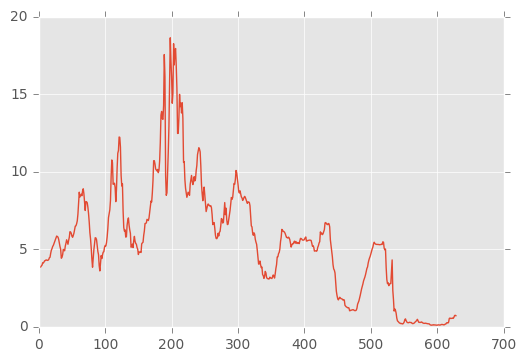

In [24]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.026327
p-value                          0.032508
#Lags Used                      18.000000
Number of Observations Used    610.000000
Critical Value (1%)             -3.441116
Critical Value (5%)             -2.866290
Critical Value (10%)            -2.569300
dtype: float64


Results of KPSS Test:
Test Statistic            1.154627
p-value                   0.010000
#Lags Used               20.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


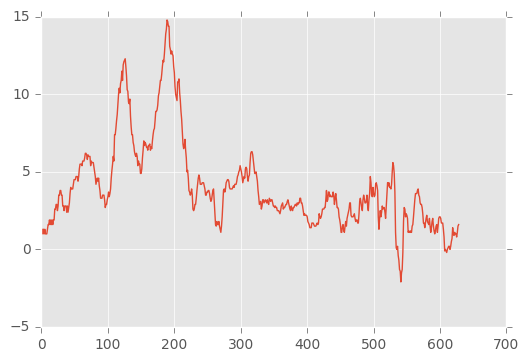

In [25]:
test_stationarity(df_var_t['infr'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.355673
p-value                          0.012566
#Lags Used                       6.000000
Number of Observations Used    622.000000
Critical Value (1%)             -3.440907
Critical Value (5%)             -2.866198
Critical Value (10%)            -2.569251
dtype: float64


Results of KPSS Test:
Test Statistic            0.24785
p-value                   0.10000
#Lags Used               20.00000
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Critical Value (5%)       0.46300
Critical Value (10%)      0.34700
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


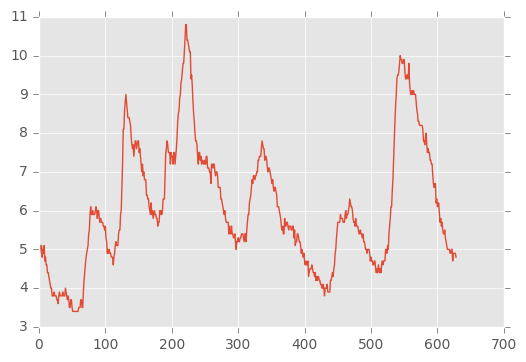

In [26]:
test_stationarity(df_var_t['umpr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                  -5.337747
p-value                          0.000005
#Lags Used                      18.000000
Number of Observations Used    609.000000
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
Critical Value (10%)            -2.569304
dtype: float64


Results of KPSS Test:
Test Statistic            0.082104
p-value                   0.100000
#Lags Used               19.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


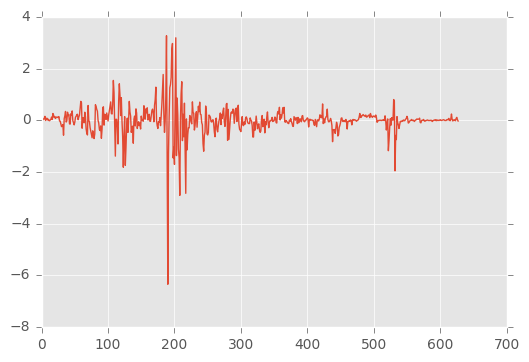

In [27]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -6.032762e+00
p-value                        1.405130e-07
#Lags Used                     1.400000e+01
Number of Observations Used    6.130000e+02
Critical Value (1%)           -3.441063e+00
Critical Value (5%)           -2.866266e+00
Critical Value (10%)          -2.569287e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.070892
p-value                   0.100000
#Lags Used               19.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


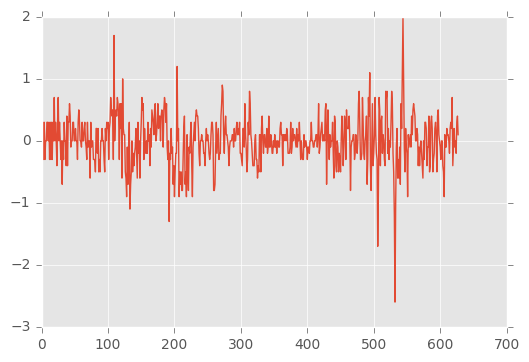

In [28]:
test_stationarity(diff_series(df_var_t['infr']))

Results of Dickey-Fuller Test:
Test Statistic                -5.880016e+00
p-value                        3.094187e-07
#Lags Used                     1.100000e+01
Number of Observations Used    6.160000e+02
Critical Value (1%)           -3.441010e+00
Critical Value (5%)           -2.866243e+00
Critical Value (10%)          -2.569275e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.055131
p-value                   0.100000
#Lags Used               19.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


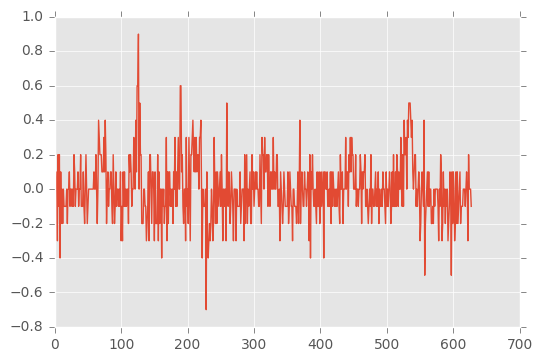

In [29]:
test_stationarity(diff_series(df_var_t['umpr']))

In [30]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

#### 6 steps

In [31]:
train = df_var_t_diff.iloc[:-6, 1:]
test = df_var_t_diff.iloc[-6:, 1:]

train_real = df_var_t.iloc[:-6, 1:]
test_real = df_var_t.iloc[-6:, 1:]

In [32]:
LAG = 2

In [33]:
STEPS = 6

### VAR

In [78]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bg

In [98]:
from statsmodels.regression.linear_model import OLS

In [99]:
import statsmodels.api as sm

In [91]:
lag = LAG

bg_df = train.copy()
cols_origin = bg_df.columns
for i in range(1,lag+1):
    shift_df = train.shift(i).copy()
    cols = []
    for c in cols_origin:
        cols.append(c+'_shift_'+str(i))
    shift_df.columns = cols
    bg_df = pd.concat([bg_df, shift_df], axis=1).dropna()


ols_df

In [96]:
ols_df = pd.concat([bg_df.iloc[:, 2], bg_df.iloc[:, 3:]], axis=1)

In [112]:
X = np.asarray(sm.add_constant(ols_df.iloc[:, 1:]))
Y = np.asarray(ols_df.iloc[:, 0])

In [120]:
model = OLS(Y,X)

In [121]:
model.fit()

TypeError: No loop matching the specified signature and casting
was found for ufunc svd_n_s

In [74]:
def var_model(train, steps, lags, years=None):
    df = np.array(train)
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [75]:
#years=train['TIME'][2:-6].reset_index(drop=True)
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:])

In [35]:
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['umpr'], test['umpr']))

{'mae': 0.044641916679026922, 'rmse': 0.061396629957696403, 'mse': 0.003769546170162303}
{'mae': 0.19338251896281042, 'rmse': 0.23178526578744582, 'mse': 0.053724409436156896}
{'mae': 0.10498919059303358, 'rmse': 0.16000416913675819, 'mse': 0.025601334141144325}


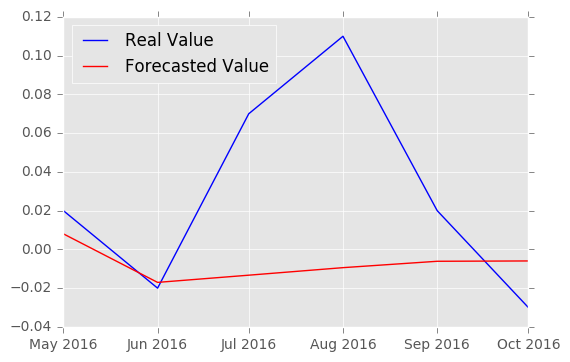

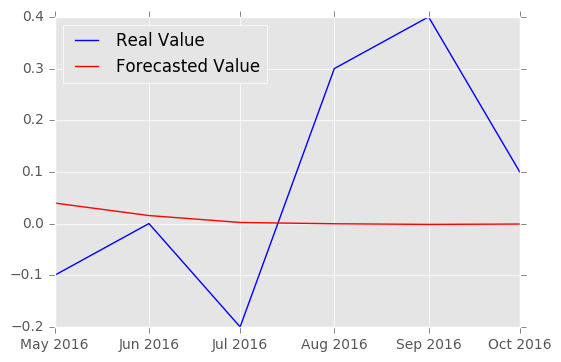

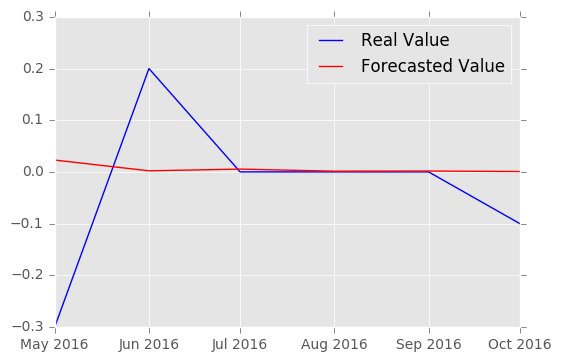

In [36]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['umpr'], test['umpr'])

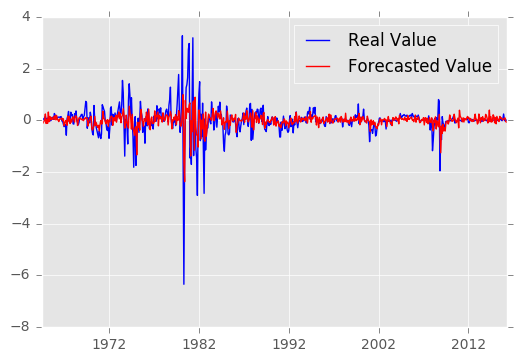

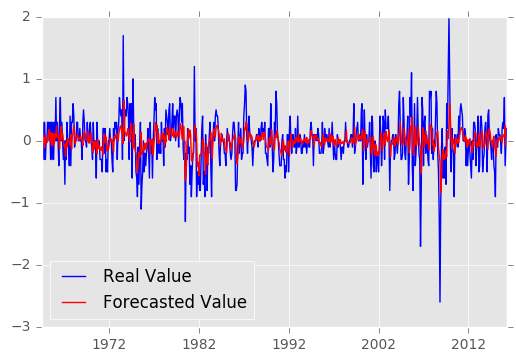

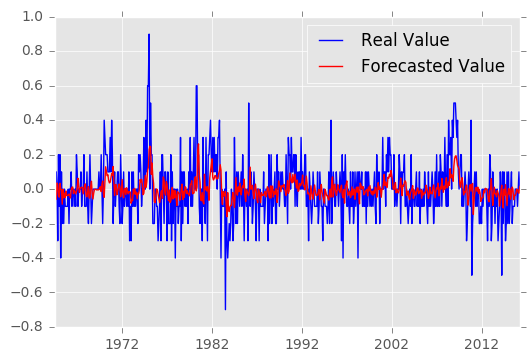

In [37]:
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['umpr'], train['umpr'])

In [117]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])

In [118]:
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])

In [119]:
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['umpr'], test_real['umpr']))

{'mae': 0.12946156307719484, 'mse': 0.025983664831574878, 'rmse': 0.16119449380042383}
{'mae': 0.24991496712994529, 'mse': 0.081993540648956365, 'rmse': 0.28634514252725918}
{'mae': 0.17958450562201392, 'mse': 0.037806824896349463, 'rmse': 0.19443977189955111}


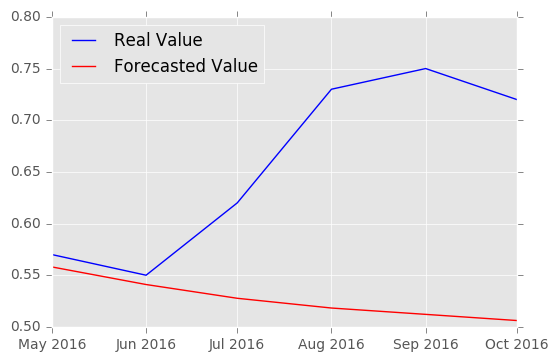

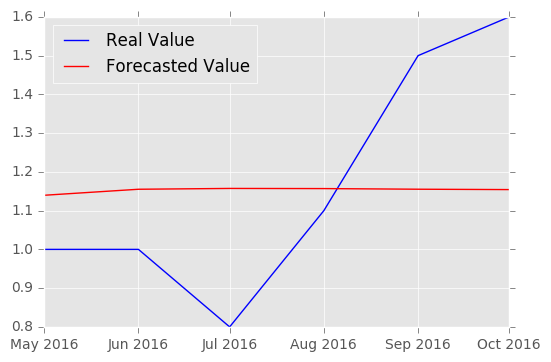

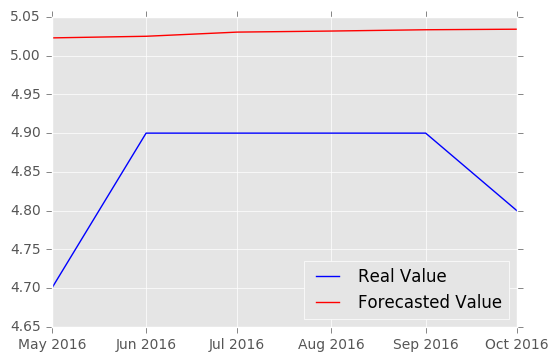

In [120]:
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])

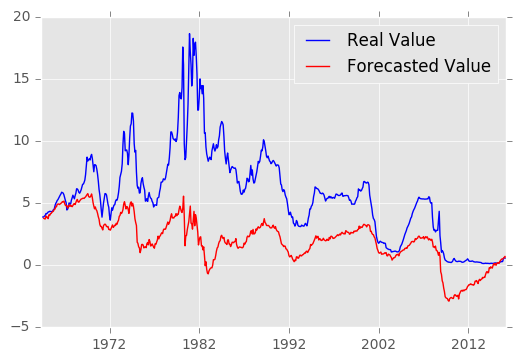

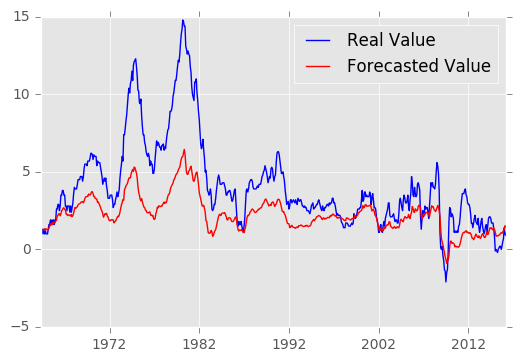

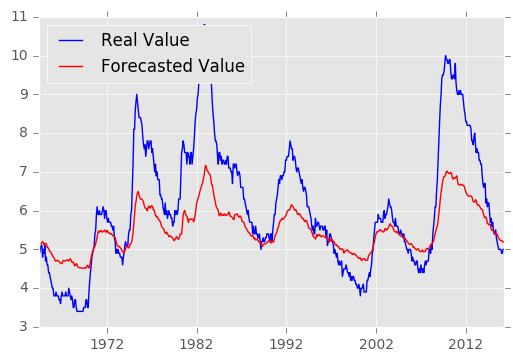

In [121]:
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

### ANN

In [122]:
df_nn = nn_transform(train, n=LAG)

In [123]:
train_nn_x = df_nn.iloc[:, 3:].copy()
train_nn_y = df_nn.iloc[:, :3].copy()

Первый запуск модели для проверки ее устойчивости

In [124]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [125]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100):
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

In [126]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=6, model=nn, 
                     years=train_nn_y.index, 
                     epoch=100)

Epoch 1/100
1s - loss: 0.3126
Epoch 2/100
0s - loss: 0.1663
Epoch 3/100
0s - loss: 0.1636
Epoch 4/100
0s - loss: 0.1617
Epoch 5/100
0s - loss: 0.1587
Epoch 6/100
0s - loss: 0.1568
Epoch 7/100
0s - loss: 0.1543
Epoch 8/100
0s - loss: 0.1515
Epoch 9/100
0s - loss: 0.1497
Epoch 10/100
0s - loss: 0.1479
Epoch 11/100
0s - loss: 0.1469
Epoch 12/100
0s - loss: 0.1451
Epoch 13/100
0s - loss: 0.1445
Epoch 14/100
0s - loss: 0.1440
Epoch 15/100
0s - loss: 0.1434
Epoch 16/100
0s - loss: 0.1427
Epoch 17/100
0s - loss: 0.1415
Epoch 18/100
0s - loss: 0.1423
Epoch 19/100
0s - loss: 0.1406
Epoch 20/100
0s - loss: 0.1411
Epoch 21/100
1s - loss: 0.1416
Epoch 22/100
0s - loss: 0.1407
Epoch 23/100
0s - loss: 0.1410
Epoch 24/100
0s - loss: 0.1401
Epoch 25/100
0s - loss: 0.1397
Epoch 26/100
0s - loss: 0.1402
Epoch 27/100
0s - loss: 0.1400
Epoch 28/100
0s - loss: 0.1396
Epoch 29/100
0s - loss: 0.1400
Epoch 30/100
0s - loss: 0.1390
Epoch 31/100
0s - loss: 0.1384
Epoch 32/100
0s - loss: 0.1390
Epoch 33/100
0s -

In [127]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'mae': 0.06263930817445118, 'mse': 0.0068007196908344237, 'rmse': 0.082466476163556443}
{'mae': 0.19456491221984229, 'mse': 0.049720500062840067, 'rmse': 0.22298094103048374}
{'mae': 0.10695647671818742, 'mse': 0.025258803661108501, 'rmse': 0.15893018486463956}


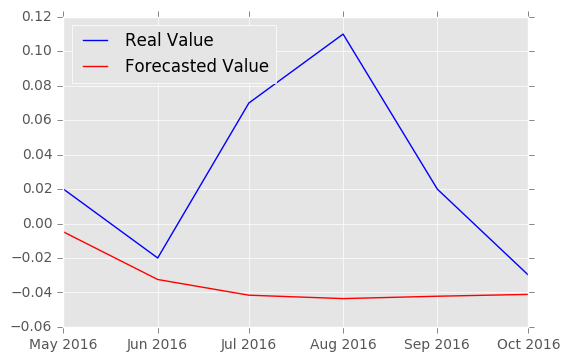

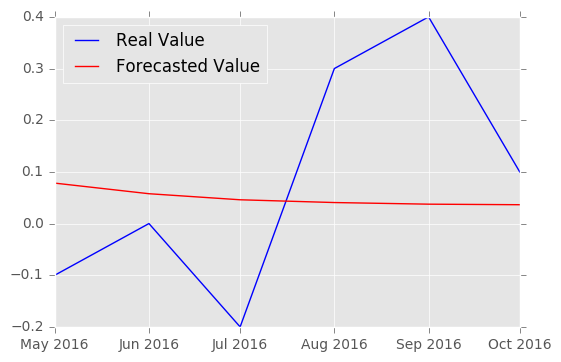

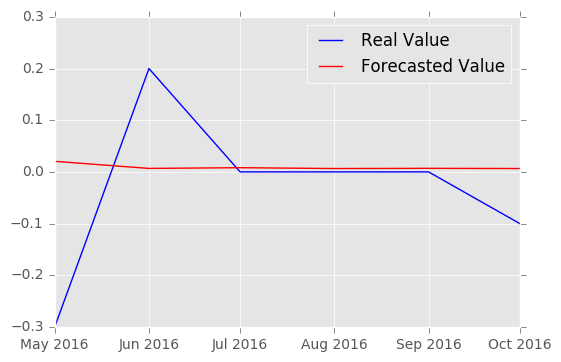

In [128]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])

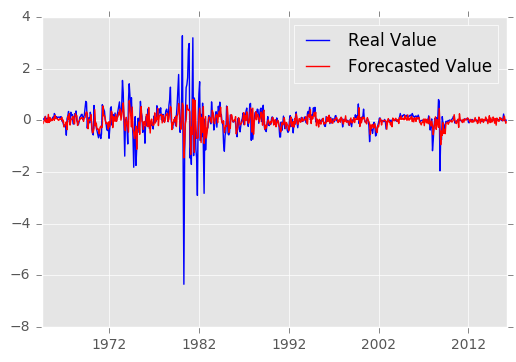

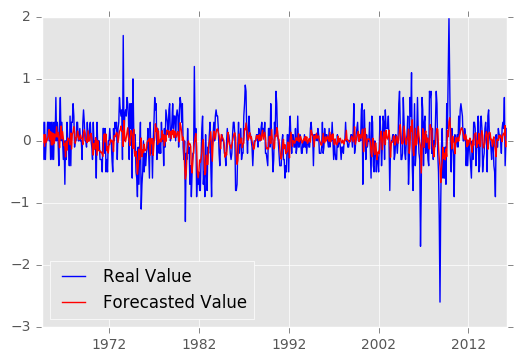

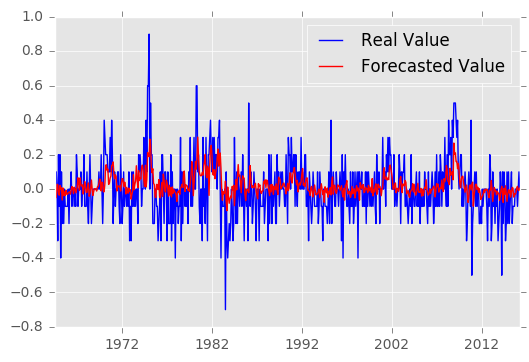

In [129]:
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

In [130]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))

{'mae': 0.20903091867764786, 'mse': 0.064994956475124571, 'rmse': 0.25494108432170082}
{'mae': 0.24368676692247393, 'mse': 0.071719747513355303, 'rmse': 0.26780542846132771}
{'mae': 0.18810129935542719, 'mse': 0.040751332569025626, 'rmse': 0.2018695929778074}


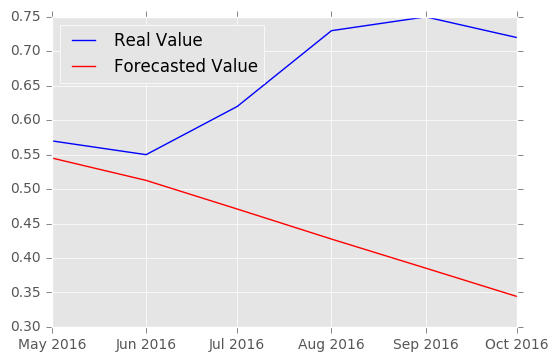

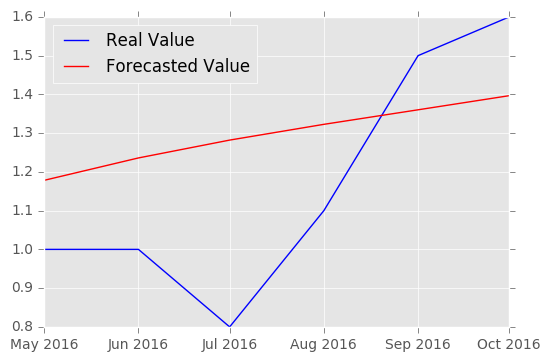

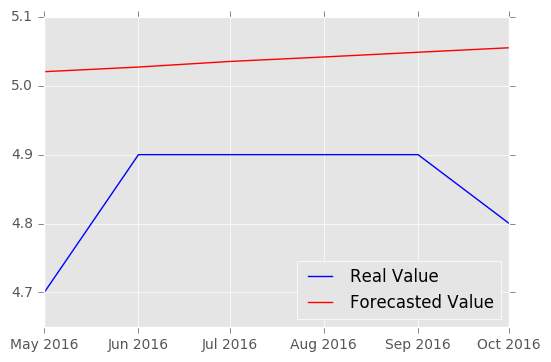

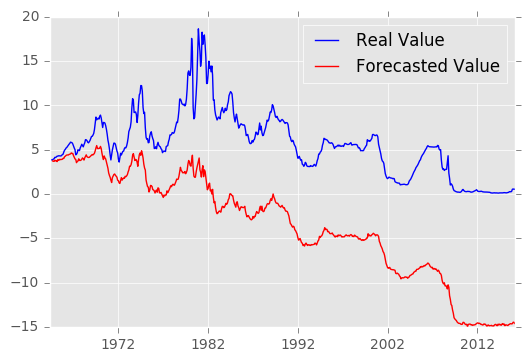

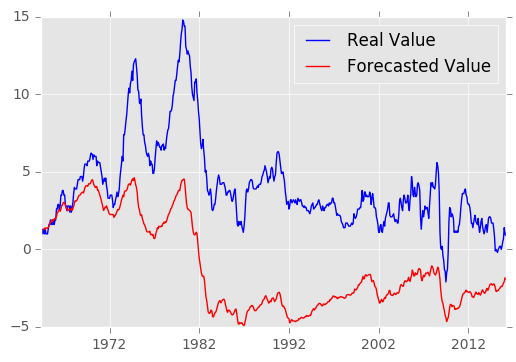

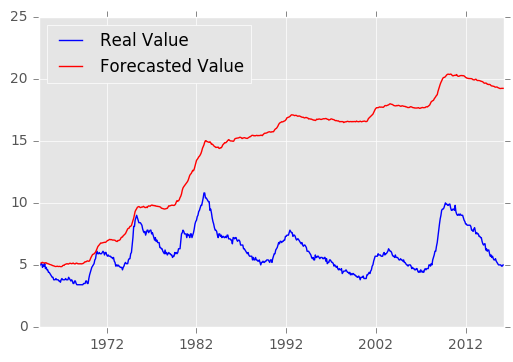

In [131]:
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

Второй запуск модели

In [132]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [133]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=6, model=nn, 
                     years=train_nn_y.index, 
                     epoch=150)

Epoch 1/150
0s - loss: 0.2233
Epoch 2/150
0s - loss: 0.1650
Epoch 3/150
0s - loss: 0.1622
Epoch 4/150
0s - loss: 0.1597
Epoch 5/150
0s - loss: 0.1567
Epoch 6/150
0s - loss: 0.1531
Epoch 7/150
0s - loss: 0.1492
Epoch 8/150
0s - loss: 0.1472
Epoch 9/150
0s - loss: 0.1450
Epoch 10/150
0s - loss: 0.1447
Epoch 11/150
0s - loss: 0.1434
Epoch 12/150
0s - loss: 0.1421
Epoch 13/150
0s - loss: 0.1410
Epoch 14/150
0s - loss: 0.1410
Epoch 15/150
0s - loss: 0.1403
Epoch 16/150
0s - loss: 0.1396
Epoch 17/150
0s - loss: 0.1391
Epoch 18/150
0s - loss: 0.1397
Epoch 19/150
0s - loss: 0.1387
Epoch 20/150
0s - loss: 0.1392
Epoch 21/150
0s - loss: 0.1391
Epoch 22/150
0s - loss: 0.1384
Epoch 23/150
0s - loss: 0.1387
Epoch 24/150
0s - loss: 0.1383
Epoch 25/150
0s - loss: 0.1381
Epoch 26/150
0s - loss: 0.1381
Epoch 27/150
0s - loss: 0.1379
Epoch 28/150
0s - loss: 0.1385
Epoch 29/150
0s - loss: 0.1385
Epoch 30/150
0s - loss: 0.1378
Epoch 31/150
0s - loss: 0.1379
Epoch 32/150
0s - loss: 0.1375
Epoch 33/150
0s -

In [134]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'mae': 0.10209725519021351, 'mse': 0.013276041339219974, 'rmse': 0.11522170515671071}
{'mae': 0.20913052906592688, 'mse': 0.065582081217778712, 'rmse': 0.25608998656288517}
{'mae': 0.10466919628282396, 'mse': 0.023921629906813058, 'rmse': 0.15466618863479198}


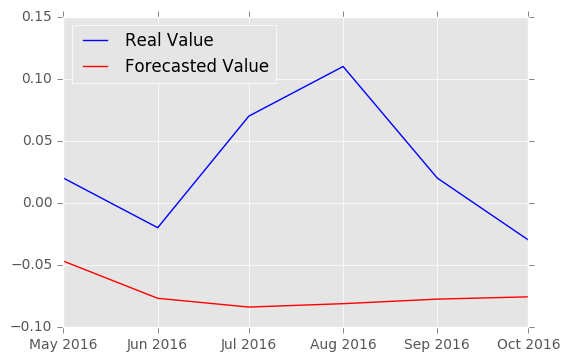

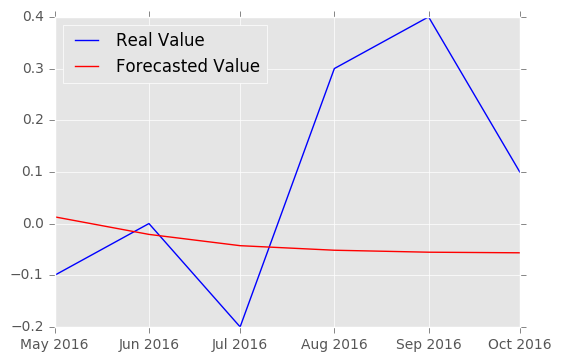

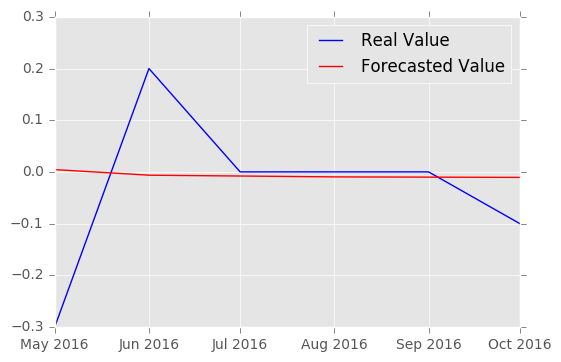

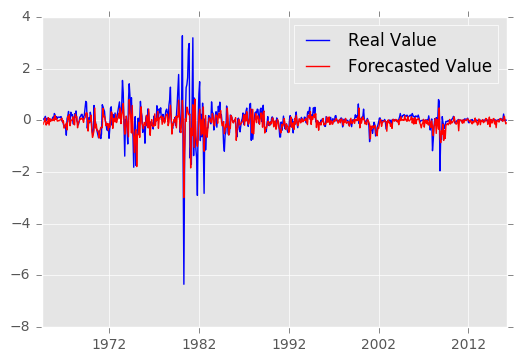

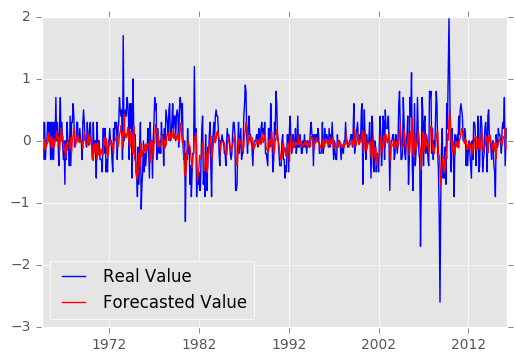

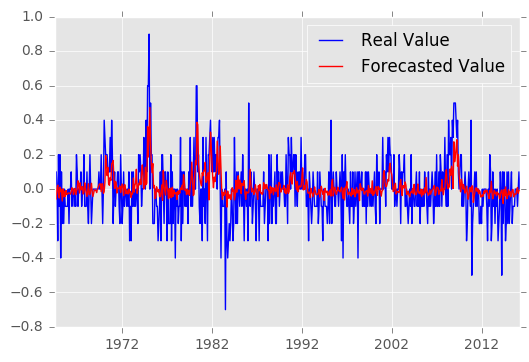

In [135]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

{'mae': 0.35291994849840796, 'mse': 0.16897075875225939, 'rmse': 0.41106052930469911}
{'mae': 0.30482797722021743, 'mse': 0.15259880292817493, 'rmse': 0.39063896749834742}
{'mae': 0.13379248504837329, 'mse': 0.024545359743570017, 'rmse': 0.15666958780685553}


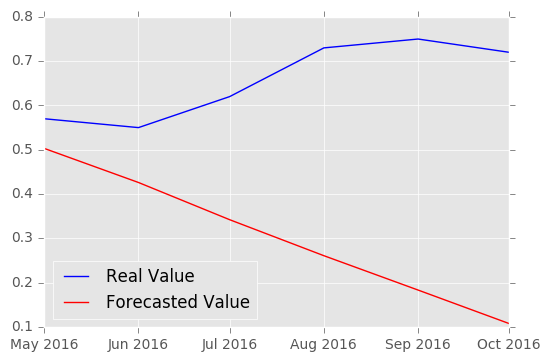

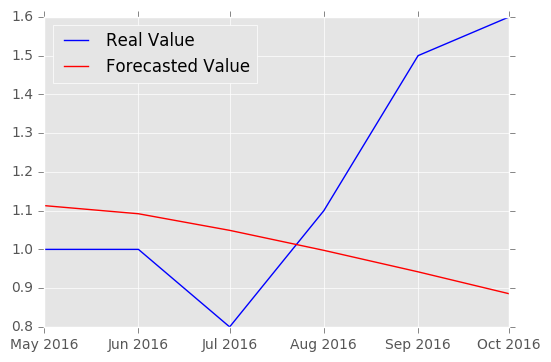

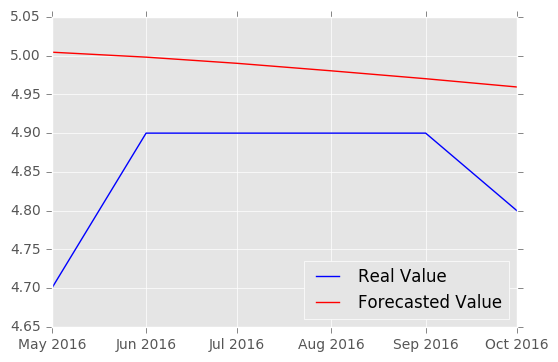

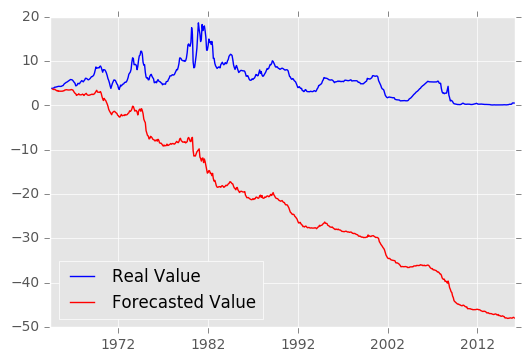

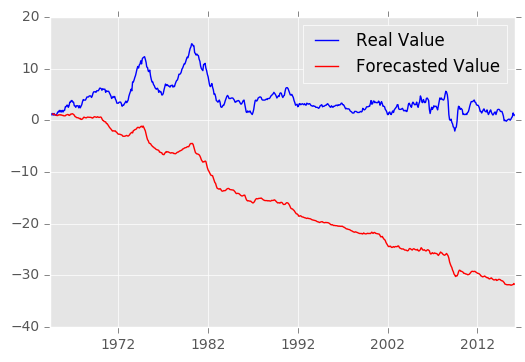

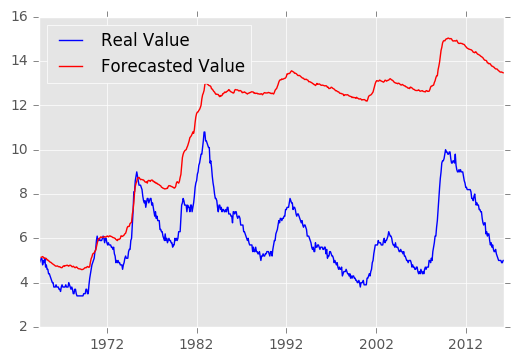

In [136]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

### Hybrid

In [137]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    train_nn_x = df_nn.iloc[:, n_feat:].copy()
    train_nn_y = df_nn.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    
    hybrid_result = pd.DataFrame(var_result + nn_result.as_matrix())
    hybrid_result.columns = train.columns
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(1, steps+1)]
        hybrid_result.index = ind
    return hybrid_result

In [138]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [139]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
0s - loss: 0.1898
Epoch 2/10
0s - loss: 0.1408
Epoch 3/10
0s - loss: 0.1411
Epoch 4/10
0s - loss: 0.1406
Epoch 5/10
0s - loss: 0.1415
Epoch 6/10
0s - loss: 0.1406
Epoch 7/10
0s - loss: 0.1408
Epoch 8/10
0s - loss: 0.1406
Epoch 9/10
0s - loss: 0.1402
Epoch 10/10
0s - loss: 0.1399


Первый запуск

In [140]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'mae': 0.12696077782978063, 'mse': 0.018683888401503004, 'rmse': 0.13668902077893091}
{'mae': 0.19696411205245049, 'mse': 0.058428767691613814, 'rmse': 0.24172043292120304}
{'mae': 0.12529001851347044, 'mse': 0.029227221856206177, 'rmse': 0.17095970828299334}


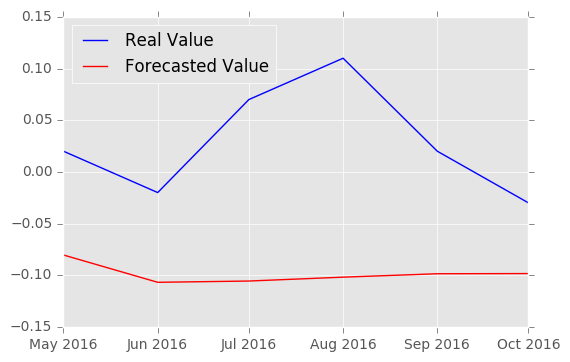

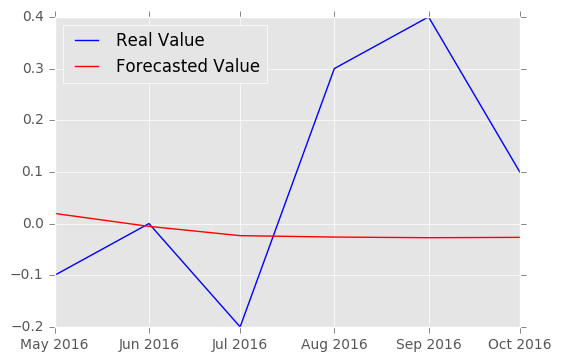

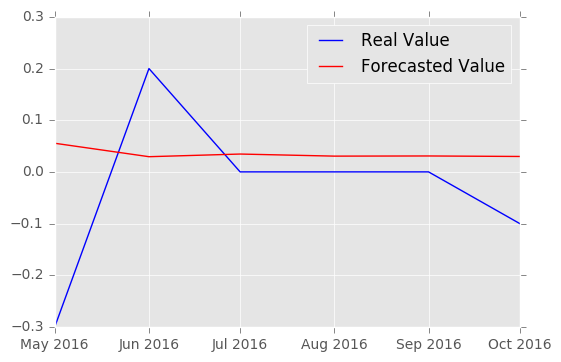

In [141]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mae': 0.44675913348458546, 'mse': 0.26138065345816924, 'rmse': 0.5112540009214297}
{'mae': 0.26869717188732439, 'mse': 0.11248161783156296, 'rmse': 0.33538279298670493}
{'mae': 0.2834420005127038, 'mse': 0.086389891640071659, 'rmse': 0.2939215739616125}


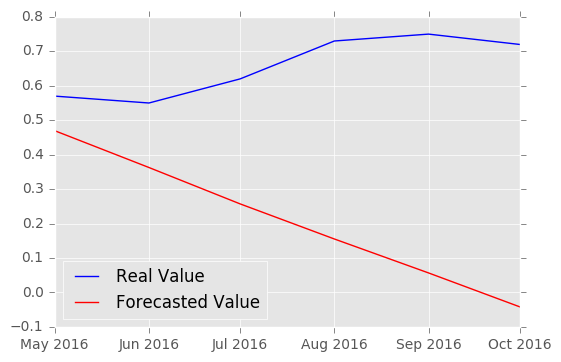

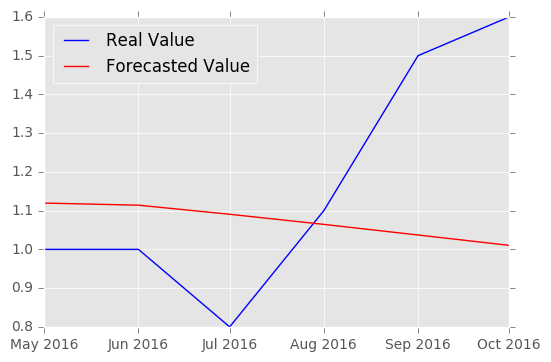

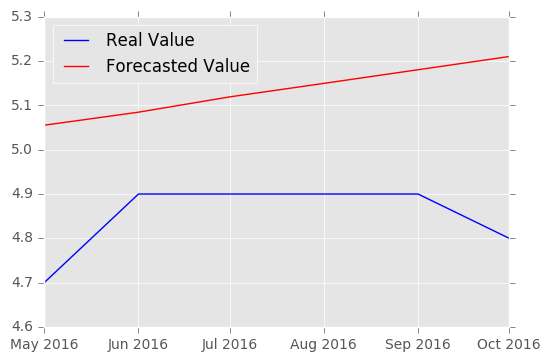

In [142]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

Второй запуск

In [143]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=6, model_nn=nn, years=True, epoch=10)

Epoch 1/10
0s - loss: 0.1436
Epoch 2/10
0s - loss: 0.1417
Epoch 3/10
0s - loss: 0.1411
Epoch 4/10
0s - loss: 0.1401
Epoch 5/10
0s - loss: 0.1413
Epoch 6/10
0s - loss: 0.1414
Epoch 7/10
0s - loss: 0.1413
Epoch 8/10
0s - loss: 0.1409
Epoch 9/10
0s - loss: 0.1408
Epoch 10/10
0s - loss: 0.1405


In [144]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'mae': 0.044284227501493224, 'mse': 0.0025630081058974894, 'rmse': 0.050626160291863821}
{'mae': 0.19536998617230852, 'mse': 0.054927867589075523, 'rmse': 0.2343669507184738}
{'mae': 0.1077789853304147, 'mse': 0.024756111832177598, 'rmse': 0.15734075070425207}


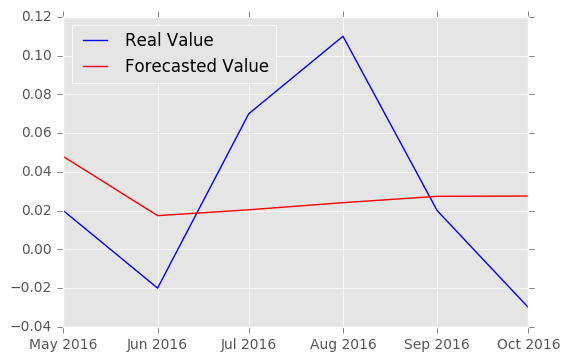

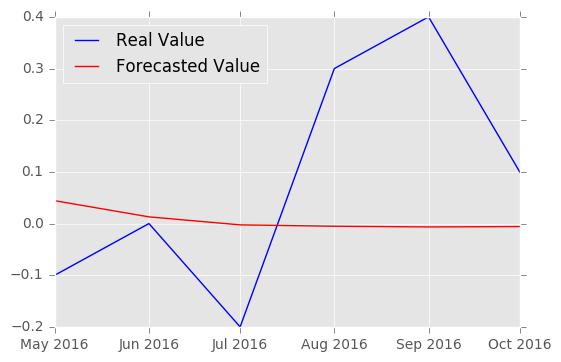

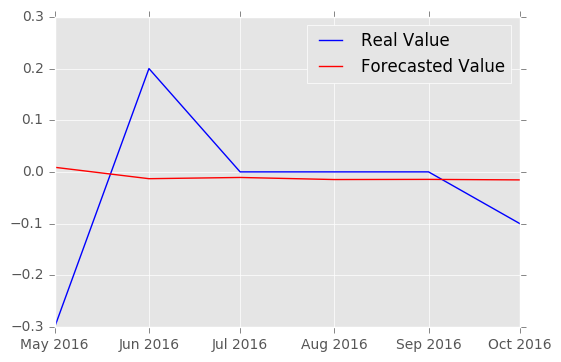

In [145]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mae': 0.041175529353066752, 'mse': 0.0023624529291865026, 'rmse': 0.04860507102336651}
{'mae': 0.25424932392097466, 'mse': 0.0859149806825215, 'rmse': 0.29311257339548147}
{'mae': 0.12589458807252299, 'mse': 0.023237273460550822, 'rmse': 0.15243776914056051}


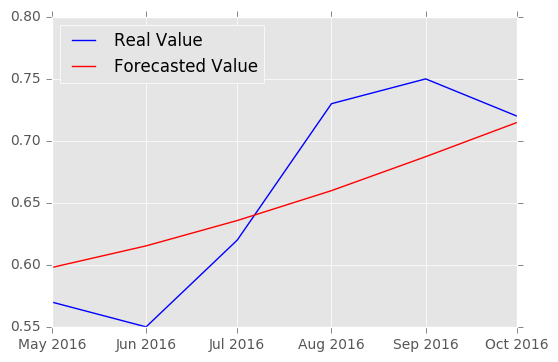

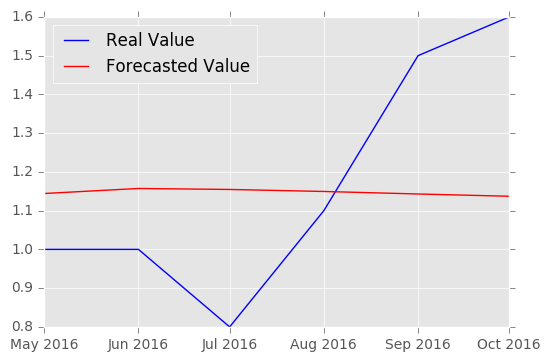

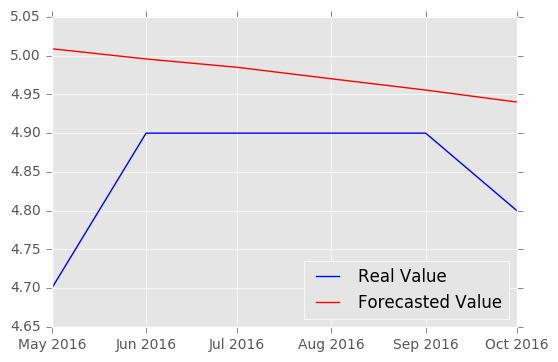

In [146]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

С DropOut

In [147]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=6, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.3454
Epoch 2/10
0s - loss: 0.1853
Epoch 3/10
0s - loss: 0.1604
Epoch 4/10
0s - loss: 0.1505
Epoch 5/10
0s - loss: 0.1457
Epoch 6/10
0s - loss: 0.1438
Epoch 7/10
0s - loss: 0.1410
Epoch 8/10
0s - loss: 0.1413
Epoch 9/10
0s - loss: 0.1405
Epoch 10/10
0s - loss: 0.1391


In [148]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'mae': 0.04075210580715137, 'mse': 0.0029627477357568881, 'rmse': 0.054431128371152548}
{'mae': 0.19369045332152646, 'mse': 0.051559231744879447, 'rmse': 0.22706657998234669}
{'mae': 0.10831586877596333, 'mse': 0.026020336573282104, 'rmse': 0.16130820367632301}


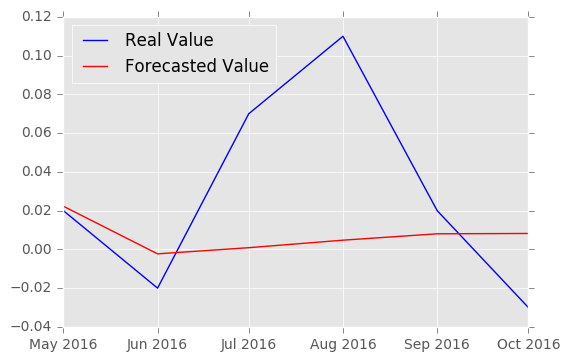

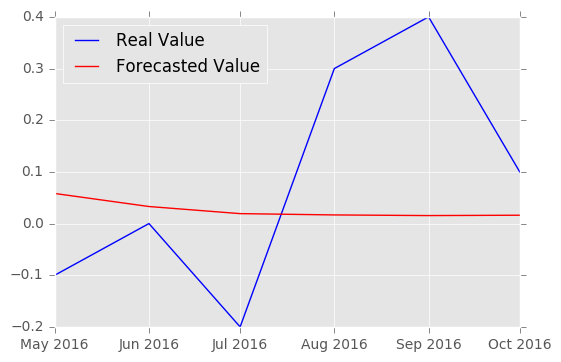

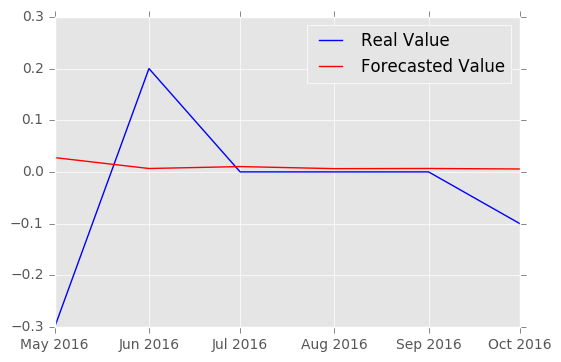

In [149]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mae': 0.086713572310701939, 'mse': 0.011791385110022616, 'rmse': 0.10858814442664823}
{'mae': 0.24761879846237056, 'mse': 0.071494913906646335, 'rmse': 0.26738532851793934}
{'mae': 0.1962401588714863, 'mse': 0.043815201481675448, 'rmse': 0.20932080995848321}


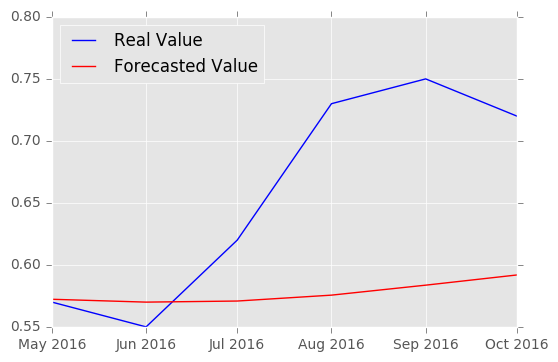

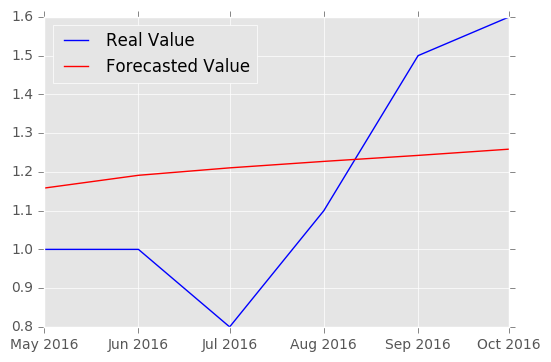

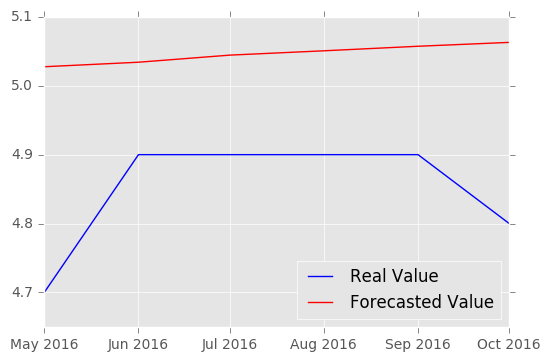

In [150]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

C DropOut 2

In [151]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=6, model_nn=nn, years=True, epoch=10)

Epoch 1/10
0s - loss: 0.3801
Epoch 2/10
0s - loss: 0.1926
Epoch 3/10
0s - loss: 0.1632
Epoch 4/10
0s - loss: 0.1492
Epoch 5/10
0s - loss: 0.1457
Epoch 6/10
0s - loss: 0.1444
Epoch 7/10
0s - loss: 0.1421
Epoch 8/10
0s - loss: 0.1413
Epoch 9/10
0s - loss: 0.1396
Epoch 10/10
0s - loss: 0.1392


{'mae': 0.093254374618128869, 'mse': 0.013904345184813862, 'rmse': 0.11791668747388498}
{'mae': 0.25149175150724207, 'mse': 0.091611847289978954, 'rmse': 0.3026744906495738}
{'mae': 0.18178453890487503, 'mse': 0.03855593501147072, 'rmse': 0.19635665257757559}


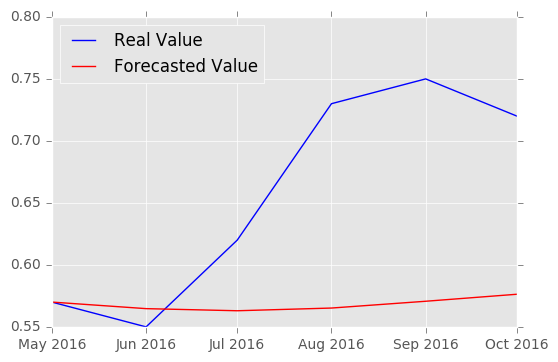

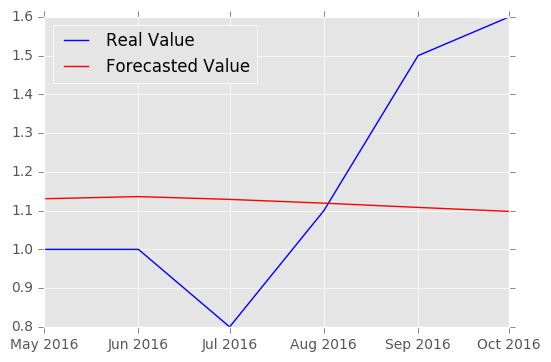

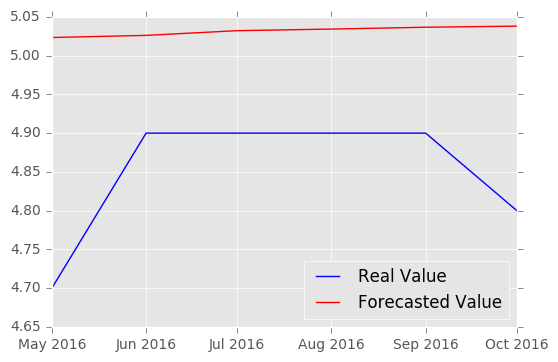

In [152]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

### Hybrid Full

In [158]:
def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [159]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
0s - loss: 0.8425
Epoch 2/500
0s - loss: 0.4779
Epoch 3/500
0s - loss: 0.3746
Epoch 4/500
0s - loss: 0.3023
Epoch 5/500
0s - loss: 0.2249
Epoch 6/500
0s - loss: 0.1656
Epoch 7/500
0s - loss: 0.1288
Epoch 8/500
1s - loss: 0.1016
Epoch 9/500
0s - loss: 0.0825
Epoch 10/500
0s - loss: 0.0710
Epoch 11/500
0s - loss: 0.0645
Epoch 12/500
0s - loss: 0.0607
Epoch 13/500
0s - loss: 0.0572
Epoch 14/500
0s - loss: 0.0540
Epoch 15/500
0s - loss: 0.0523
Epoch 16/500
0s - loss: 0.0505
Epoch 17/500
0s - loss: 0.0482
Epoch 18/500
0s - loss: 0.0475
Epoch 19/500
0s - loss: 0.0465
Epoch 20/500
0s - loss: 0.0450
Epoch 21/500
0s - loss: 0.0443
Epoch 22/500
0s - loss: 0.0438
Epoch 23/500
0s - loss: 0.0426
Epoch 24/500
0s - loss: 0.0420
Epoch 25/500
0s - loss: 0.0413
Epoch 26/500
0s - loss: 0.0411
Epoch 27/500
0s - loss: 0.0405
Epoch 28/500
0s - loss: 0.0398
Epoch 29/500
0s - loss: 0.0395
Epoch 30/500
0s - loss: 0.0389
Epoch 31/500
0s - loss: 0.0392
Epoch 32/500
0s - loss: 0.0379
Epoch 33/500
0s -

{'mae': 3.750172793997633, 'mse': 14.072662489599907, 'rmse': 3.7513547538989038}
{'mae': 0.99469418684514999, 'mse': 1.1524876692439132, 'rmse': 1.0735397846581716}
{'mae': 0.41754702949345895, 'mse': 0.18500134407899507, 'rmse': 0.43011782580938807}


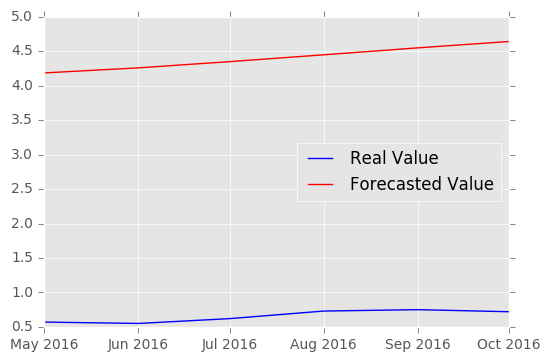

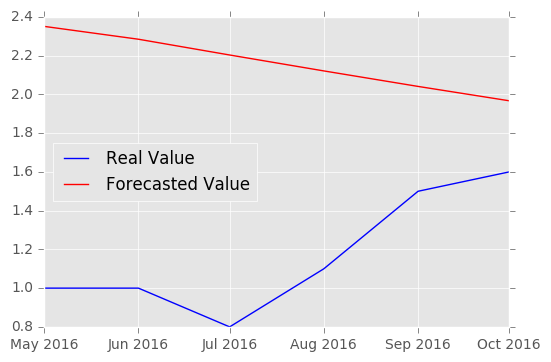

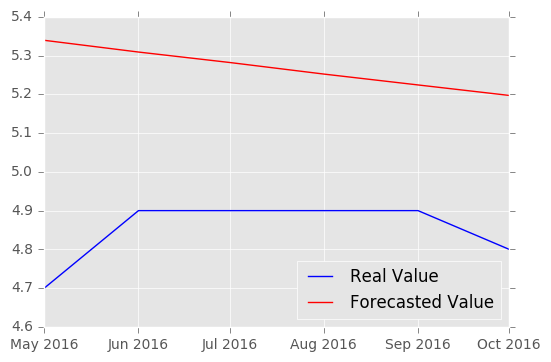

In [160]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

Второй запуск

In [165]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 0.9566
Epoch 2/500
0s - loss: 0.5936
Epoch 3/500
0s - loss: 0.4275
Epoch 4/500
0s - loss: 0.3415
Epoch 5/500
1s - loss: 0.2494
Epoch 6/500
1s - loss: 0.1673
Epoch 7/500
1s - loss: 0.1155
Epoch 8/500
1s - loss: 0.0873
Epoch 9/500
1s - loss: 0.0729
Epoch 10/500
1s - loss: 0.0648
Epoch 11/500
1s - loss: 0.0600
Epoch 12/500
1s - loss: 0.0563
Epoch 13/500
1s - loss: 0.0543
Epoch 14/500
1s - loss: 0.0517
Epoch 15/500
1s - loss: 0.0499
Epoch 16/500
1s - loss: 0.0483
Epoch 17/500
1s - loss: 0.0473
Epoch 18/500
2s - loss: 0.0452
Epoch 19/500
1s - loss: 0.0444
Epoch 20/500
1s - loss: 0.0440
Epoch 21/500
1s - loss: 0.0431
Epoch 22/500
1s - loss: 0.0425
Epoch 23/500
1s - loss: 0.0415
Epoch 24/500
1s - loss: 0.0409
Epoch 25/500
1s - loss: 0.0405
Epoch 26/500
1s - loss: 0.0402
Epoch 27/500
1s - loss: 0.0393
Epoch 28/500
1s - loss: 0.0388
Epoch 29/500
1s - loss: 0.0383
Epoch 30/500
1s - loss: 0.0380
Epoch 31/500
1s - loss: 0.0377
Epoch 32/500
1s - loss: 0.0378
Epoch 33/500
1s -

{'mae': 3.7924321630020583, 'mse': 14.401278770194978, 'rmse': 3.7949016812290379}
{'mae': 1.0762079460541314, 'mse': 1.2985720577249422, 'rmse': 1.1395490589373247}
{'mae': 0.57504363477692866, 'mse': 0.33566480234368917, 'rmse': 0.57936586225259179}


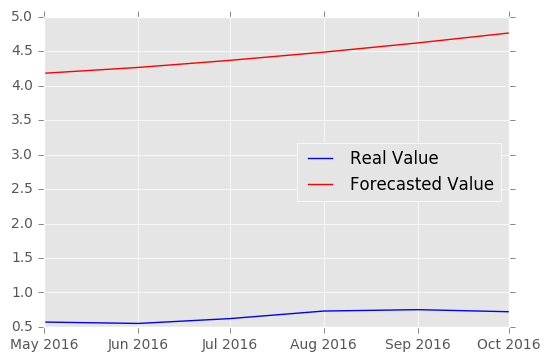

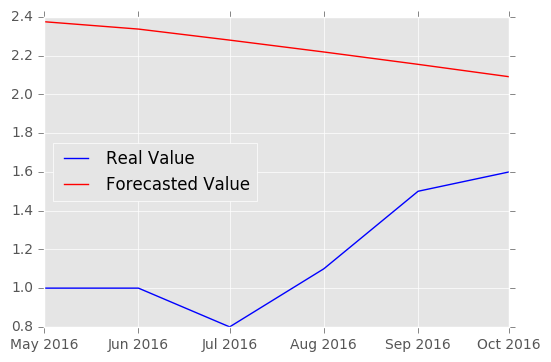

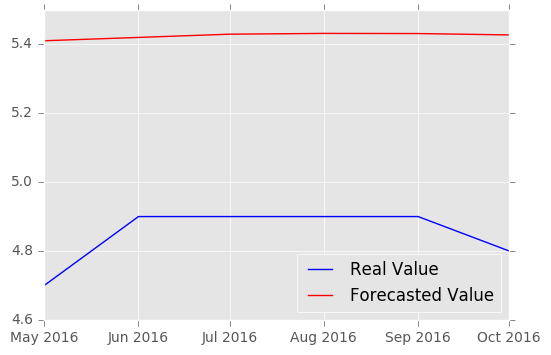

In [166]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

С DropOut

In [167]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.0341
Epoch 2/500
0s - loss: 0.9678
Epoch 3/500
0s - loss: 0.8778
Epoch 4/500
0s - loss: 0.7679
Epoch 5/500
0s - loss: 0.6904
Epoch 6/500
0s - loss: 0.6728
Epoch 7/500
0s - loss: 0.6165
Epoch 8/500
0s - loss: 0.6372
Epoch 9/500
0s - loss: 0.5979
Epoch 10/500
0s - loss: 0.6058
Epoch 11/500
0s - loss: 0.5829
Epoch 12/500
0s - loss: 0.5827
Epoch 13/500
0s - loss: 0.5765
Epoch 14/500
0s - loss: 0.5950
Epoch 15/500
0s - loss: 0.5630
Epoch 16/500
0s - loss: 0.5802
Epoch 17/500
0s - loss: 0.5684
Epoch 18/500
0s - loss: 0.5508
Epoch 19/500
0s - loss: 0.5498
Epoch 20/500
0s - loss: 0.5437
Epoch 21/500
0s - loss: 0.5326
Epoch 22/500
0s - loss: 0.5437
Epoch 23/500
0s - loss: 0.5223
Epoch 24/500
0s - loss: 0.5341
Epoch 25/500
0s - loss: 0.5257
Epoch 26/500
0s - loss: 0.5430
Epoch 27/500
0s - loss: 0.5284
Epoch 28/500
0s - loss: 0.5453
Epoch 29/500
0s - loss: 0.5240
Epoch 30/500
0s - loss: 0.5397
Epoch 31/500
0s - loss: 0.5434
Epoch 32/500
0s - loss: 0.5174
Epoch 33/500
0s -

{'mae': 3.9981402550654916, 'mse': 16.041927689356651, 'rmse': 4.0052375322016358}
{'mae': 1.7195147740399672, 'mse': 2.9845266667594994, 'rmse': 1.7275782664642141}
{'mae': 0.45020973821200538, 'mse': 0.21336938764777971, 'rmse': 0.46191924364306336}


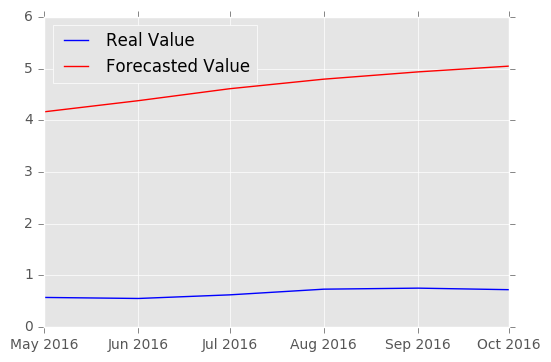

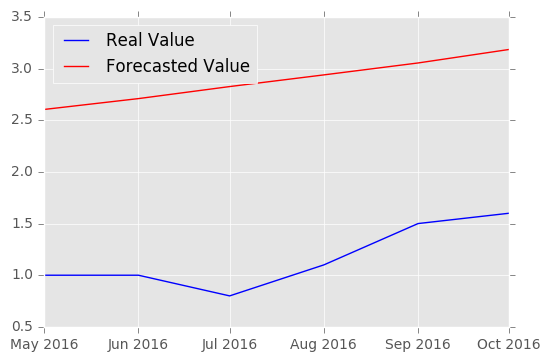

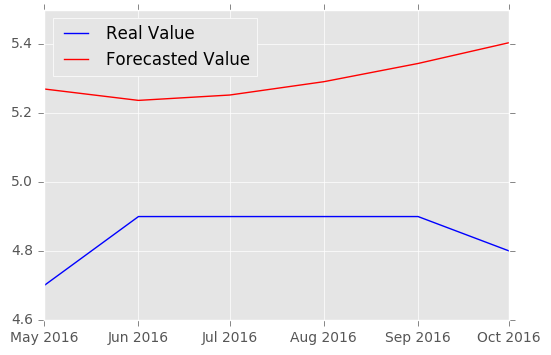

In [168]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])